##데이터 전처리

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#데이터 불러오기
f1=pd.read_csv("/content/drive/MyDrive/전기_분석_데이터/제주전력시장_현황데이터.csv")
f2=pd.read_csv("/content/drive/MyDrive/전기_분석_데이터/제주전력시장_시장전기가격_실시간가격.csv")#실제 가격이 들어있는 데이터
f3=pd.read_csv("/content/drive/MyDrive/전기_분석_데이터/기상실측데이터_1.csv")
f4=pd.read_csv("/content/drive/MyDrive/전기_분석_데이터/기상실측데이터_2.csv")
f5=pd.read_csv("/content/drive/MyDrive/전기_분석_데이터/제주전력시장_시장전기가격_하루전가격.csv")

In [ ]:
import pandas as pd
from datetime import timedelta

# 한국 시간으로 변환하고 날짜와 시간 추가
f1['datetime'] = pd.to_datetime(f1['ts'], unit='s') + timedelta(hours=9)
f1['date'] = f1['datetime'].dt.date
f1['time'] = f1['datetime'].dt.time

# 오전 9시 기준으로 데이터 선택
f1_sorted = f1.sort_values(by=['date', 'datetime'])

# 각 날짜에서 오전 9시 또는 그 이전의 가장 가까운 데이터 선택
f_new_1 = f1_sorted[f1_sorted['time'] <= pd.to_datetime("09:00:00").time()].groupby('date').last().reset_index()

# 결과 확인
print(f_new_1)


           date          ts   공급능력(kW)  현재 수요(kW)  태양광 발전량kW)  풍력 발전량(kW)  \
0    2024-01-01  1704067200  1204000.0   656000.0    35839.20     4526.81   
1    2024-01-02  1704153600  1209000.0   774000.0    43513.40     2954.55   
2    2024-01-03  1704240000  1313000.0   900000.0     5001.39   144820.00   
3    2024-01-04  1704326400  1296000.0   818000.0    47125.80    11550.20   
4    2024-01-05  1704412800  1280000.0   826000.0    27452.80    16506.80   
..          ...         ...        ...        ...         ...         ...   
291  2024-10-19  1729296000  1245000.0   618000.0    32120.80   123040.00   
292  2024-10-20  1729382400  1357000.0   568000.0    40407.50   208063.00   
293  2024-10-21  1729468800  1210000.0   646000.0    37747.80    72464.20   
294  2024-10-22  1729555200  1121000.0   658000.0    92975.70    69287.40   
295  2024-10-23  1729609200  1254000.0   599000.0        0.00   248589.00   

     신재생 발전량 총합(kW)  공급 예비력(kW)  운영 예비력(kW)            datetime      time  

In [ ]:
import pandas as pd
from datetime import timedelta

# 예제 f_new_1 데이터프레임이 있다고 가정하고 시작
# f_new_1에는 각 날짜별 오전 9시 데이터만 포함되어 있음

# 새로운 데이터프레임을 저장할 리스트
expanded_data = []

# 각 날짜별로 9시 데이터를 기준으로 1시간 간격으로 24시간 데이터 생성
for _, row in f_new_1.iterrows():
    # 9시 기준으로 24시간 동안 1시간 간격으로 데이터 생성
    for hour_offset in range(24):
        new_row = row.copy()  # 기존 데이터 복사
        new_row['datetime'] = row['datetime'] + timedelta(hours=hour_offset)  # 1시간씩 더함
        new_row['ts'] = int(new_row['datetime'].timestamp())  # 새로운 datetime을 타임스탬프로 변환
        expanded_data.append(new_row)

# 확장된 데이터를 데이터프레임으로 변환
f_new_new_1 = pd.DataFrame(expanded_data)

f1=f_new_new_1


In [ ]:
import pandas as pd
from datetime import timedelta
# 예제 f1 데이터프레임이 있다고 가정하고 시작

# 분과 초가 모두 0인 경우만 필터링
hour_f1 = f1[(f1['datetime'].dt.minute == 0) & (f1['datetime'].dt.second == 0)]


# 예제 f1 데이터프레임이 있다고 가정하고 시작

# 날짜만 추출해서 새로운 컬럼 생성
hour_f1['temp_date'] = hour_f1['datetime'].dt.date

# 각 날짜별 00:00:00의 공급능력(kW)와 현재 수요(kW) 값을 추출하여 하루 전날의 데이터에 적용
base_values = hour_f1[hour_f1['datetime'].dt.time == pd.to_datetime("00:00:00").time()][['temp_date', '공급능력(kW)', '현재 수요(kW)']]
base_values['temp_date'] = base_values['temp_date'] - timedelta(days=1)  # 하루 전날에 적용할 수 있도록 날짜를 1일 뒤로 이동

# f1과 base_values를 날짜 기준으로 병합하여 하루 전의 데이터에 해당 날짜의 00:00:00 값으로 설정
hour_f1 = hour_f1.merge(base_values, on='temp_date', how='left', suffixes=('', '_base'))

# NaN이 아닌 값만 업데이트하고, NaN인 경우 기존 값 유지
hour_f1.loc[hour_f1['공급능력(kW)_base'].notna(), '공급능력(kW)'] = hour_f1['공급능력(kW)_base']
hour_f1.loc[hour_f1['현재 수요(kW)_base'].notna(), '현재 수요(kW)'] = hour_f1['현재 수요(kW)_base']

# 임시 컬럼 삭제
hour_f1.drop(columns=['공급능력(kW)_base', '현재 수요(kW)_base', 'temp_date'], inplace=True)

# 결과 확인
hour_f1


<ipython-input-191-53f250406c2f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hour_f1['temp_date'] = hour_f1['datetime'].dt.date


,date,ts,공급능력(kW),현재 수요(kW),태양광 발전량kW),풍력 발전량(kW),신재생 발전량 총합(kW),공급 예비력(kW),운영 예비력(kW),datetime,time
0,2024-01-01,1704099600,1204000.0,656000.0,35839.2,4526.81,46396.0,548000.0,392000.0,2024-01-01 09:00:00,09:00:00
1,2024-01-01,1704103200,1204000.0,656000.0,35839.2,4526.81,46396.0,548000.0,392000.0,2024-01-01 10:00:00,09:00:00
2,2024-01-01,1704106800,1204000.0,656000.0,35839.2,4526.81,46396.0,548000.0,392000.0,2024-01-01 11:00:00,09:00:00
3,2024-01-01,1704110400,1204000.0,656000.0,35839.2,4526.81,46396.0,548000.0,392000.0,2024-01-01 12:00:00,09:00:00
4,2024-01-01,1704114000,1204000.0,656000.0,35839.2,4526.81,46396.0,548000.0,392000.0,2024-01-01 13:00:00,09:00:00
...,...,...,...,...,...,...,...,...,...,...,...
7099,2024-10-23,1729710000,1254000.0,599000.0,0.0,248589.00,257082.0,650000.0,303000.0,2024-10-23 19:00:00,00:00:00
7100,2024-10-23,1729713600,1254000.0,599000.0,0.0,248589.00,257082.0,650000.0,303000.0,2024-10-23 20:00:00,00:00:00
7101,2024-10-23,1729717200,1254000.0,599000.0,0.0,248589.00,257082.0,650000.0,303000.0,2024-10-23 21:00:00,00:00:00
7102,2024-10-23,1729720800,1254000.0,599000.0,0.0,248589.00,257082.0,650000.0,303000.0,2024-10-23 22:00:00,00:00:00


In [ ]:
f1=hour_f1

In [ ]:
#f1_f2_f3로 시험 해보는 코드 밑에서 linear(25,128) 로 바꿔야함 그리고 신경망 좀 더 쌓고

# 숫자로 변환 불가능한 값들은 NaN으로 설정
f2['ts'] = pd.to_numeric(f2['ts'], errors='coerce')
f3['ts'] = pd.to_numeric(f3['ts'], errors='coerce')
f4['ts'] = pd.to_numeric(f4['ts'], errors='coerce')

# NaN 값이 포함된 행 제거
f2 = f2.dropna(subset=['ts'])
f3 = f3.dropna(subset=['ts'])
f4 = f4.dropna(subset=['ts'])

# ts를 int로 변환
f2['ts'] = f2['ts'].astype(int)
f3['ts'] = f3['ts'].astype(int)-86400#n-1일 제주 기상 실측
f4['ts'] = f4['ts'].astype(int)-86400#n-1일 제주 기상 실측

f4['ts'] = f4['ts'] - ((f4['ts'] % 3600))
f3['ts'] = f3['ts'] - ((f3['ts'] % 3600))
f5['ts']=f5['ts']  #n일데이터
f1['ts']= f1['ts']-86400 #n-1일 제주 전력시장 현황

merged_df_f1_f5 = pd.merge(f1, f5, on='ts', how='inner')
merged_df_f1_f5_f4 = pd.merge(merged_df_f1_f5, f4, on='ts', how='inner')
merged_df_f1_f5_f3_f4 =pd.merge(merged_df_f1_f5_f4, f3, on='ts', how='inner')
temp_merged_1=merged_df_f1_f5_f3_f4[0:2200000]
temp_merged_2=merged_df_f1_f2_f3_f4[222001:]

temp_merged_1 = temp_merged_1.sample(frac=1).reset_index(drop=True)

y = temp_merged_1["하루전가격(원/kWh)"]
X = temp_merged_1.drop(columns=["location_x","ts","하루전가격(원/kWh)","datetime","date","time","location_y"])


<ipython-input-193-4d9c1c1b364a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f3['ts'] = f3['ts'].astype(int)-86400#n-1일 제주 기상 실측
<ipython-input-193-4d9c1c1b364a>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f4['ts'] = f4['ts'].astype(int)-86400#n-1일 제주 기상 실측
<ipython-input-193-4d9c1c1b364a>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [ ]:
a_X["location_y"]

,location_y
0,Cheju-do
1,Gaigeturi
2,Jeju
3,Cheju-do
4,Gaigeturi
...,...
2357280,Gaigeturi
2357281,Jeju
2357282,Cheju-do
2357283,Gaigeturi


##customloss로 학습

In [12]:
import torch

def customloss(predict, y):#학습용
    # predict를 y와 같은 차원으로 변환
    predict = predict.squeeze()  # (batch_size, 1) -> (batch_size,)

    e1 = torch.zeros_like(y)
    e2 = torch.zeros_like(y)
    accuracy = torch.zeros_like(y)

    positive_mask = y > 0
    negative_mask = y <= 0

    e1_mask = y > 0  # y > 0인 부분 마스크
    e2_mask = y < -1  # y <= 0인 부분 마스크
    e2_adjusted_mask = (y <= 0) & (y >= -1)
    # 각 마스크 조건에 맞는 부분에 대해서만 e1, e2를 계산합니다.
    # e1과 e2에서 분모에 작은 상수를 추가하여 0으로 나누는 것을 방지
    e1[e1_mask] = torch.abs((y[e1_mask] - predict[e1_mask]) / (y[e1_mask]))
    e2[e2_mask] = torch.abs((y[e2_mask] - predict[e2_mask]) / (-y[e2_mask]))
    e2[e2_adjusted_mask] = torch.abs((y[e2_adjusted_mask] - predict[e2_adjusted_mask]) / (-1))

    accuracy[positive_mask] = (predict[positive_mask] > 0).float()
    accuracy[negative_mask] = (predict[negative_mask] <= 0).float()

    e1_mean = e1[e1 != 0].mean() if (e1 != 0).any() else torch.tensor(0.0)
    e2_mean = e2[e2 != 0].mean() if (e2 != 0).any() else torch.tensor(0.0)

    accuracy_mean = accuracy.mean()

    e_F = 0.2 * e1_mean + 0.8 * e2_mean - (accuracy_mean - 0.95)
    if e_F<0:
      e_F=0
    e_F_square = e_F**2
    mse_loss = torch.mean((y - predict)**2)

    return e_F_square*10 + mse_loss

In [13]:
a_X

,공급능력(kW),현재 수요(kW),태양광 발전량kW),풍력 발전량(kW),신재생 발전량 총합(kW),공급 예비력(kW),운영 예비력(kW),temp_x,real_feel_temp,real_feel_temp_shade,...,cloud_forecast,temp_forecast_y,temp_max_forecast,temp_min_forecast,humidity_forecast,ground_press_forecast,wind_speed_forecast,wind_dir_forecast_y,rain_forecast_y,snow_forecast_y
0,1173000.0,830000.0,0.0,34779.200,48403.400,343000.0,261000.0,4.711111,2.077778,2.077778,...,100.000000,1.213333,1.213333,1.213333,60.333333,1027.000000,8.306667,332.333333,0.0,0.0
1,1169000.0,811000.0,0.0,34019.300,46486.000,358000.0,273000.0,4.962500,1.650000,1.650000,...,100.000000,1.280000,1.280000,1.280000,61.000000,1027.000000,8.043333,333.666667,0.0,0.0
2,1176000.0,793000.0,0.0,38075.700,52466.900,383000.0,304000.0,4.836364,0.918182,0.918182,...,100.000000,1.323333,1.323333,1.323333,60.666667,1026.666667,7.626667,333.000000,0.0,0.0
3,1181000.0,772000.0,0.0,43493.300,58308.400,410000.0,327000.0,4.666667,1.811111,1.811111,...,100.000000,1.323333,1.323333,1.323333,60.666667,1026.000000,7.310000,332.666667,0.0,0.0
4,1180000.0,764000.0,0.0,42580.100,56826.100,416000.0,315000.0,4.910000,1.240000,1.240000,...,96.333333,1.356667,1.356667,1.356667,60.666667,1026.000000,7.076667,331.666667,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5852,1033000.0,483000.0,0.0,1113.990,1239.090,500000.0,377000.0,15.808333,15.425000,15.425000,...,16.000000,16.986667,16.986667,16.986667,77.333333,1022.666667,6.080000,78.333333,0.0,0.0
5853,1083000.0,518000.0,0.0,723.548,856.235,516000.0,392000.0,15.722222,16.100000,16.100000,...,16.666667,16.890000,16.890000,16.890000,77.000000,1023.000000,6.243333,80.000000,0.0,0.0
5854,1115000.0,521000.0,31335.7,1268.080,32728.200,544000.0,420000.0,16.600000,17.291667,16.400000,...,16.000000,17.056667,17.056667,17.056667,75.666667,1023.666667,6.130000,83.000000,0.0,0.0
5855,1206000.0,544000.0,126056.0,441.744,126622.000,642000.0,439000.0,17.625000,19.700000,17.616667,...,14.666667,17.890000,17.890000,17.890000,71.666667,1024.000000,6.286667,83.666667,0.0,0.0


In [14]:
train_X, val_X, test_X = a_X[0:5000],a_X[5000:5800],a_X[5800:5850]
train_y, val_y, test_y = a_y[0:5000], a_y[5000:5800],a_y[5800:5850]

# Normalize 제거 - X와 y 모두 원래 스케일 사용

# 2. Dataset and DataLoader
class CustomDataset(Dataset):
    def __init__(self, X, y):
        X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
        y = y.apply(pd.to_numeric, errors='coerce').fillna(0)

        self.X = torch.tensor(X.to_numpy(), dtype=torch.float32)
        self.y = torch.tensor(y.to_numpy(), dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# DataLoaders
batch_size = 2**9
train_dataset = CustomDataset(train_X, train_y)
val_dataset = CustomDataset(val_X, val_y)
test_dataset = CustomDataset(test_X, test_y)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 3. Model definition
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

# Device setting
device = "cuda" if torch.cuda.is_available() else "cpu"
model = NeuralNetwork().to(device)
print(model)

# MSELoss 정의
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# 5. Training function
def train(dataloader, model, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        pred = model(X)
        loss = customloss(pred,y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch % 10 == 0:
            current = batch * len(X)
            print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

    avg_loss = total_loss / len(dataloader)
    print(f"Average training loss: {avg_loss:>8f}")

# 6. Validation function
def validate(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss = customloss(pred,y)
            total_loss += loss
    avg_loss = total_loss / num_batches
    print(f"Validation Error: Avg loss: {avg_loss:>8f}")

# 7. Training loop
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, optimizer)
    validate(val_dataloader, model)
print("Done!")

# Run test
print("Testing on unseen data:")


NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=32, bias=True)
    (11): ReLU()
    (12): Linear(in_features=32, out_features=8, bias=True)
    (13): ReLU()
    (14): Linear(in_features=8, out_features=1, bias=True)
  )
)
Epoch 1
-------------------------------
loss: 702637.187500  [    0/ 5000]
Average training loss: 303776.717383
Validation Error: Avg loss: 26082.341797
Epoch 2
-------------------------------
loss: 48574.839844  [    0/ 5000]
Average training loss: 25100.299023
Validation Error: Avg loss: 11965.859375
Epoch 3
--------------------------

In [15]:
epochs = 200

optimizer = optim.Adam(model.parameters(), lr=1e-4)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, optimizer)
    validate(val_dataloader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 16870.095703  [    0/ 5000]
Average training loss: 30743.713574
Validation Error: Avg loss: 9503.128906
Epoch 2
-------------------------------
loss: 10673.906250  [    0/ 5000]
Average training loss: 8126.091553
Validation Error: Avg loss: 7984.535156
Epoch 3
-------------------------------
loss: 5316.108398  [    0/ 5000]
Average training loss: 6579.056982
Validation Error: Avg loss: 8002.574219
Epoch 4
-------------------------------
loss: 6636.085938  [    0/ 5000]
Average training loss: 6272.642944
Validation Error: Avg loss: 9869.808594
Epoch 5
-------------------------------
loss: 6725.906250  [    0/ 5000]
Average training loss: 6324.863477
Validation Error: Avg loss: 8068.079590
Epoch 6
-------------------------------
loss: 6186.824707  [    0/ 5000]
Average training loss: 5392.562036
Validation Error: Avg loss: 8183.555664
Epoch 7
-------------------------------
loss: 5410.861328  [    0/ 5000]
Average training loss: 5739.605371
V

In [ ]:
import torch

# 모델 학습이 완료된 후, 학습된 가중치를 저장
torch.save(model, path)

#평가 부분

In [31]:
y_2=temp_merged_2["실시간 확정 가격(원/kWh)"]
X_2=temp_merged_2.drop(columns=["실시간 확정 가격(원/kWh)","실시간 임시 가격(원/kWh)","ts","location_x"])

NameError: name 'temp_merged_2' is not defined

In [16]:
import torch

def customloss_actual(predict, y):
    # predict와 y가 batch 단위로 입력된다고 가정하고 수정
    # predict와 y는 각각 (batch_size,) 또는 (batch_size, num_features) 형태의 tensor라고 가정

    # e1과 e2는 배치 내 모든 샘플에 대해 계산되므로 각 배치 크기만큼의 0 텐서를 초기화
    e1 = torch.zeros_like(y)
    e2 = torch.zeros_like(y)
    accuracy = torch.zeros_like(y)  # batch 내 샘플 개수만큼의 accuracy 초기화

    # y > 0인 경우 e1을 계산하고, y <= 0인 경우 e2를 계산합니다.
    # 이를 위해 boolean indexing을 사용하여 조건에 맞는 요소들만 선택합니다.
    e1_mask = y > 0  # y > 0인 부분 마스크
    e2_mask = y < -1  # y <= 0인 부분 마스크
    e2_adjusted_mask = (y <= 0) & (y >= -1)
    # 각 마스크 조건에 맞는 부분에 대해서만 e1, e2를 계산합니다.
    # e1과 e2에서 분모에 작은 상수를 추가하여 0으로 나누는 것을 방지
    e1[e1_mask] = torch.abs((y[e1_mask] - predict[e1_mask]) / (y[e1_mask]))
    e2[e2_mask] = torch.abs((y[e2_mask] - predict[e2_mask]) / (-y[e2_mask]))
    e2[e2_adjusted_mask] = torch.abs((y[e2_adjusted_mask] - predict[e2_adjusted_mask]) / (-1))


    # 정확도 계산: y > 0일 때 predict도 > 0, y <= 0일 때 predict도 <= 0이면 accuracy = 1
    accuracy[e1_mask] = (predict[e1_mask] > 0).float()  # y > 0일 때 predict > 0이면 1
    accuracy[e2_mask] = (predict[e2_mask] <= 0).float()  # y <= 0일 때 predict <= 0이면 1

    # e_F 계산: e1과 e2의 weighted sum - (accuracy - 0.95)
    e_F = 0.2 * e1 + 0.8 * e2 - (accuracy - 0.95)

    # e_F를 제곱하여 loss 값으로 반환합니다.
    # e_F는 각 샘플에 대한 값이므로 최종 loss는 batch 차원에 대해 평균을 취합니다.
    e_F_square = e_F**2

    e1_non_zero_mean = e1[e1 != 0].mean() if (e1 != 0).any() else torch.tensor(0.0)
    e2_non_zero_mean = e2[e2 != 0].mean() if (e2 != 0).any() else torch.tensor(0.0)
    mean_difference = torch.abs((predict - y)).mean()

    print("accuracy는 ",accuracy.mean())
    print(f"e1 (0 제외 평균): {e1_non_zero_mean}")
    print(f"e2 (0 제외 평균): {e2_non_zero_mean}")
    print("e_F의 값은",e_F.mean())
    print("e_f의 길이는:",len(e_F))
    print("predict와 y의 평균 차이는 ",mean_difference)
    return e_F_square.mean()  # batch-wise 평균 loss 반환

모델 예측 검증 부분

In [17]:
test_X =a_X
test_y =a_y
batch_size = 64

test_dataset = CustomDataset(test_X, test_y)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
import pandas as pd

def predict_and_compare(dataloader, model):
    model.eval()  # 모델을 평가 모드로 전환
    predictions = []
    actuals = []

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for X, y in dataloader:
            X = X.to(device)
            pred = model(X)  # 예측 값 반환

            # pred가 단일 값인지 텐서인지 확인하여 처리
            if pred.dim() == 0:  # pred가 단일 값일 경우
                predictions.append(pred.item())  # 단일 값을 리스트에 추가
            else:
                predictions.extend(pred.squeeze().tolist())  # 1차원 텐서일 경우 리스트로 변환하여 추가

            actuals.extend(y.tolist())  # 실제 값 리스트에 추가

    # DataFrame 생성
    df = pd.DataFrame({
        'Actual': actuals,
        'Predicted': predictions
    })

    return df

# 테스트 데이터셋을 통해 예측 및 비교
result_df = predict_and_compare(test_dataloader, model)
result_df


,Actual,Predicted
0,112.190002,136.533401
1,138.500000,133.673798
2,99.480003,130.763412
3,95.379997,127.255646
4,91.239998,126.082603
...,...,...
5852,92.449997,89.534111
5853,92.449997,94.723984
5854,92.699997,83.875870
5855,104.629997,0.187184


In [19]:
import torch
import pandas as pd

# 예측 및 실제 값 비교 후 result_df 생성 (위 코드에서 구현된 함수 사용)
#result_df = predict_and_compare(test_dataloader, model)

# DataFrame을 텐서로 변환
y_tensor = torch.tensor(result_df['Actual'].values, dtype=torch.float32)
predict_tensor = torch.tensor(result_df['Predicted'].values, dtype=torch.float32)

# customloss 함수에 텐서 입력
loss = customloss_actual(predict_tensor, y_tensor)
print(f"Custom Loss: {loss.item()}")


accuracy는  tensor(0.9573)
e1 (0 제외 평균): 0.292894184589386
e2 (0 제외 평균): 12.618218421936035
e_F의 값은 tensor(0.4796)
e_f의 길이는: 5857
predict와 y의 평균 차이는  tensor(40.7041)
Custom Loss: 25.784828186035156


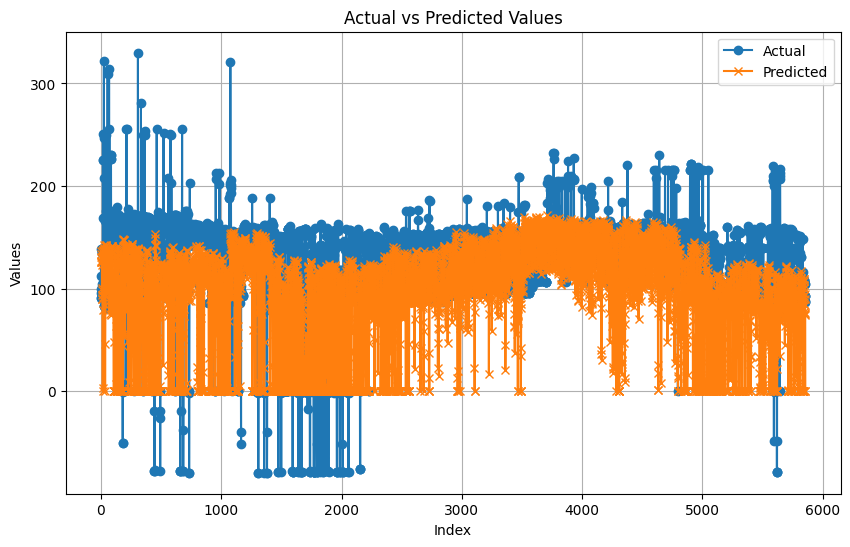

In [20]:
import matplotlib.pyplot as plt

# Sample data to simulate the user's `result_df` with 'Actual' and 'Predicted' columns
import pandas as pd
import numpy as np

# Creating a sample DataFrame to represent result_df with 'Actual' and 'Predicted' columns


# Plotting the 'Actual' and 'Predicted' values in a line graph
plt.figure(figsize=(10, 6))
plt.plot(result_df.index, result_df['Actual'], label='Actual', marker='o')
plt.plot(result_df.index, result_df['Predicted'], label='Predicted', marker='x')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
a_X=a_X.drop(columns=["하루전가격(원/kWh)"])

In [ ]:
a_X

,공급능력(kW),현재 수요(kW),태양광 발전량kW),풍력 발전량(kW),신재생 발전량 총합(kW),공급 예비력(kW),운영 예비력(kW),cloud,temp_x,temp_max,...,wind_gust_spd,uv_idx,vis,cld_cvr,ceiling,pressure,appr_temp,wind_chill_temp,wet_bulb_temp,precip_1h
0,1388000.0,798000.0,0.0,234165.0,248660.0,590000.0,266000.0,95.0,3.23,3.23,...,11.1,0.0,16.1,100.0,1219.0,1022.0,8.9,5.6,5.2,0.0
1,1388000.0,798000.0,0.0,234165.0,248660.0,590000.0,266000.0,95.0,3.23,3.23,...,17.6,0.0,20.9,91.0,579.0,1015.9,10.0,7.2,7.1,0.1
2,1388000.0,798000.0,0.0,234165.0,248660.0,590000.0,266000.0,95.0,3.23,3.23,...,12.9,0.0,22.5,100.0,762.0,1022.0,10.0,6.7,7.2,0.0
3,1388000.0,798000.0,0.0,234165.0,248660.0,590000.0,266000.0,95.0,3.23,3.23,...,31.8,0.0,17.7,97.0,579.0,1022.0,6.1,0.6,2.5,0.0
4,1388000.0,798000.0,0.0,234165.0,248660.0,590000.0,266000.0,95.0,3.23,3.23,...,16.0,0.0,17.7,97.0,579.0,1022.0,8.3,6.7,4.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4776961,1295000.0,591000.0,0.0,226052.0,226173.0,699000.0,416000.0,100.0,18.96,18.96,...,29.3,0.0,4.8,100.0,3139.0,1015.2,20.6,18.3,18.1,5.8
4776962,1295000.0,591000.0,0.0,226052.0,226173.0,699000.0,416000.0,100.0,19.96,19.96,...,32.5,0.0,4.8,100.0,4389.0,1014.6,20.0,18.3,17.2,7.4
4776963,1295000.0,591000.0,0.0,226052.0,226173.0,699000.0,416000.0,100.0,19.96,19.96,...,29.4,0.0,4.8,100.0,4389.0,1015.2,20.6,19.4,18.6,5.8
4776964,1295000.0,591000.0,0.0,226052.0,226173.0,699000.0,416000.0,100.0,19.96,19.96,...,26.7,0.0,4.8,100.0,3139.0,1014.6,20.6,19.4,18.9,4.4


##예측 부분

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd

In [2]:
a1=pd.read_csv("/content/elec_supply.csv") #5분 단위
a2=pd.read_csv("/content/smp_da.csv") #1시간 단위
a3=pd.read_csv("/content/actual_weather_2.csv") #1시간 단위지만 00분 00초가 아님
a4=pd.read_csv("/content/actual_weather_1.csv") #30분 단위
a5=pd.read_csv("/content/weather_forecast_1.csv") #1시간 단위
a6=pd.read_csv("/content/weather_forecast_2.csv") #1시간 단위

In [3]:
# 보기 좋은 한국 시간으로 바꾸기(9시간 추가 꼭 해주기!)
from datetime import datetime, timedelta

a1['ts'] = pd.to_datetime(a1['ts'], unit='s') + timedelta(hours=9)
a2['ts'] = pd.to_datetime(a2['ts'], unit='s') + timedelta(hours=9)
a3['ts'] = pd.to_datetime(a3['ts'], unit='s') + timedelta(hours=9)
a4['ts'] = pd.to_datetime(a4['ts'], unit='s') + timedelta(hours=9)
a5['ts'] = pd.to_datetime(a5['ts'], unit='s') + timedelta(hours=9)
a6['ts'] = pd.to_datetime(a6['ts'], unit='s') + timedelta(hours=9)

In [4]:
# a1은 00분 00초인 것만 데이터에 넣기
a1 = a1[(a1['ts'].dt.minute == 0) & (a1['ts'].dt.second == 0)]

# 'ts' 열에서 조건을 만족하지 않는 행들을 필터링하여 삭제
a4 = a4[a4['ts'].apply(lambda x: x.minute <= 20 or x.minute >= 40)]

# 20분 미만이면 버리고 40분 이상이면 올림
a3['ts'] = a3['ts'].apply(lambda x: x.floor('h') if x.minute <= 20 else x.ceil('h') if x.minute >= 40 else x.replace(minute=30, second=0))
a4['ts'] = a4['ts'].apply(lambda x: x.floor('h') if x.minute <= 20 else x.ceil('h'))

# 지역과 ts가 같을 때는 마지막 데이터만 남기고 다 삭제
a3 = a3[~a3.duplicated(subset=['location','ts'], keep='last')]

In [5]:
new_a5 = pd.DataFrame()
new_a6 = pd.DataFrame()

# a5의 ts 열을 제외하고 나머지 열에 "_forecast" 추가
for name in a5.columns:
    if name == 'ts':
        new_a5['ts'] = a5['ts']  # ts 열은 그대로 유지
    else:
        new_a5[name + "_forecast"] = a5[name]

# a6의 ts 열을 제외하고 나머지 열에 "_forecast" 추가
for name in a6.columns:
    if name == 'ts':
        new_a6['ts'] = a6['ts']  # ts 열은 그대로 유지
    else:
        new_a6[name + "_forecast"] = a6[name]

# 결과 확인
a5 = new_a5
a6 = new_a6

In [6]:
# location 빼버리기

a3.drop(columns=["location"],inplace=True)
a4.drop(columns=["location"],inplace=True)
a5.drop(columns=["base_ts_forecast","location_forecast"],inplace=True)
a6.drop(columns=["base_ts_forecast","location_forecast"],inplace=True)

In [7]:
# 날짜(년월일시분초)가 똑같은 경우의 평균을 내기

a3_grouped = a3.groupby('ts', as_index=False).mean()
a4_grouped = a4.groupby('ts', as_index=False).mean()
a5_grouped = a5.groupby('ts', as_index=False).mean()
a6_grouped = a6.groupby('ts', as_index=False).mean()

a3 = a3_grouped
a4 = a4_grouped
a5 = a5_grouped
a6 = a6_grouped

In [8]:
# n+1일을 구하는 거니 1일 빼기

a1['ts'] = a1['ts'] - timedelta(days=1)
a3['ts'] = a3['ts'] - timedelta(days=1)
a4['ts'] = a4['ts'] - timedelta(days=1)

In [9]:
# 데이터프레임 병합

merged_df_a1_a2 = pd.merge(a1, a2, on='ts', how='inner')
merged_df_a1_a2_a4 = pd.merge(merged_df_a1_a2, a4, on='ts', how='inner')
merged_df_a1_a2_a3_a4 = pd.merge(merged_df_a1_a2_a4, a3, on='ts', how='inner')
merged_df_a1_a2_a3_a4_a5 = pd.merge(merged_df_a1_a2_a3_a4, a5, on='ts', how='inner')
merged_df_a1_a2_a3_a4_a5_a6 = pd.merge(merged_df_a1_a2_a3_a4_a5, a6, on='ts', how='inner')


temp_merged_1 = merged_df_a1_a2_a3_a4_a5_a6
temp_merged_1


# X와 y 설정
a_y = temp_merged_1["하루전가격(원/kWh)"]
a_X = temp_merged_1.drop(columns=["ts","하루전가격(원/kWh)"])


In [11]:
a_X

,공급능력(kW),현재 수요(kW),태양광 발전량kW),풍력 발전량(kW),신재생 발전량 총합(kW),공급 예비력(kW),운영 예비력(kW),temp_x,real_feel_temp,real_feel_temp_shade,...,cloud_forecast,temp_forecast_y,temp_max_forecast,temp_min_forecast,humidity_forecast,ground_press_forecast,wind_speed_forecast,wind_dir_forecast_y,rain_forecast_y,snow_forecast_y
0,1173000.0,830000.0,0.0,34779.200,48403.400,343000.0,261000.0,4.711111,2.077778,2.077778,...,100.000000,1.213333,1.213333,1.213333,60.333333,1027.000000,8.306667,332.333333,0.0,0.0
1,1169000.0,811000.0,0.0,34019.300,46486.000,358000.0,273000.0,4.962500,1.650000,1.650000,...,100.000000,1.280000,1.280000,1.280000,61.000000,1027.000000,8.043333,333.666667,0.0,0.0
2,1176000.0,793000.0,0.0,38075.700,52466.900,383000.0,304000.0,4.836364,0.918182,0.918182,...,100.000000,1.323333,1.323333,1.323333,60.666667,1026.666667,7.626667,333.000000,0.0,0.0
3,1181000.0,772000.0,0.0,43493.300,58308.400,410000.0,327000.0,4.666667,1.811111,1.811111,...,100.000000,1.323333,1.323333,1.323333,60.666667,1026.000000,7.310000,332.666667,0.0,0.0
4,1180000.0,764000.0,0.0,42580.100,56826.100,416000.0,315000.0,4.910000,1.240000,1.240000,...,96.333333,1.356667,1.356667,1.356667,60.666667,1026.000000,7.076667,331.666667,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5852,1033000.0,483000.0,0.0,1113.990,1239.090,500000.0,377000.0,15.808333,15.425000,15.425000,...,16.000000,16.986667,16.986667,16.986667,77.333333,1022.666667,6.080000,78.333333,0.0,0.0
5853,1083000.0,518000.0,0.0,723.548,856.235,516000.0,392000.0,15.722222,16.100000,16.100000,...,16.666667,16.890000,16.890000,16.890000,77.000000,1023.000000,6.243333,80.000000,0.0,0.0
5854,1115000.0,521000.0,31335.7,1268.080,32728.200,544000.0,420000.0,16.600000,17.291667,16.400000,...,16.000000,17.056667,17.056667,17.056667,75.666667,1023.666667,6.130000,83.000000,0.0,0.0
5855,1206000.0,544000.0,126056.0,441.744,126622.000,642000.0,439000.0,17.625000,19.700000,17.616667,...,14.666667,17.890000,17.890000,17.890000,71.666667,1024.000000,6.286667,83.666667,0.0,0.0
